# Feature Engineering

In [1]:
# Author information
__author__ = "Troy Reynolds"
__email__ = "Troy.Lloyd.Reynolds@gmail.com"

In [2]:
# libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import inspect
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, PolynomialFeatures
from statistics import mean, stdev

# Extend the directory to get created functions
sys.path.insert(0, "./function_scripts")

# import helper functions
from data_import_functions import get_data
from Preprocessing import change_variables, cv_mse_stats
from results import plot_results

In [3]:
# load in the data
data = get_data("train", key = "jobId", target_variable = "salary", remove_zeros = True)

# drop id variables besides JobID for pairing in baseline regressor
features = data.drop(["jobId","companyId", "salary"], axis = 1)
target = data["salary"]

# seperate categorical and numerical variables
num_features = features.select_dtypes(include="int64")
cat_features = features.select_dtypes(include="O")

# Preview of original features
features.head()

,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,CFO,MASTERS,MATH,HEALTH,10,83
1,CEO,HIGH_SCHOOL,NONE,WEB,3,73
2,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38
3,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17
4,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16


## Feature Transformation Class

#### Binary transformation
As discussed in the Exploratory Data Analysis notebook, there is little variation amongst salaries of higher education and amongst no higher education requirement. The conversion of degree to a binary variable may improve model accuracy.

#### Interactions
Also discussed in the Exploratory Data Analysis notebook, there is interaction between industry and major. Adding features to account for this interaction could improve accuracy in linear models. It will not be implemented in tree-based models because tree-based models already account for interactions intuitively. So, the two options will be tested against each other: full polynomial regression and only adding industry-major interaction terms.

Note that we are including the original features that the interactions are based on because those feature still offer individual contribution towards the target variable.

#### Transformer class
The preprocessing class will have options for both degree binary transformation, inclusion of interaction terms, and feature elimination.

In [4]:
print(inspect.getsource(change_variables))

class change_variables(BaseEstimator, TransformerMixin):
    """
    Prepares the data for subsequent modeling
    
    Parameters
    cols_to_delete: list(String) of columns to delete
    change_degree: turn degree into a boolean that represents having an advanced degree        
    
    Methods
    fit: Nothing
    transform: Changes the features of the dataset
    """
    def __init__(self, cols_to_delete = None, change_degree = False, interactions = False):
        self.change_degree = change_degree
        self.interactions = interactions
        self.cols_to_delete = cols_to_delete
            
        
    def fit(self, X, y = None):
        # there is nothing to be fitted
        return self
    
    def transform(self, X, y = None):
        # create a copy
        X_copy = X.copy()
        
        # degree change
        if self.change_degree: 
            X_copy["higher_ed"] = np.where((X['degree'] == "NONE") | (X['degree'] == "HIGH_SCHOOL"), 0, 1)
            X_copy = X_cop

In [5]:
# change degree
degree_changer = change_variables(change_degree  = True)
degree_features = degree_changer.transform(features)
display(degree_features.head())

# conserve memory
del degree_features

,jobType,major,industry,yearsExperience,milesFromMetropolis,higher_ed
0,CFO,MATH,HEALTH,10,83,1
1,CEO,NONE,WEB,3,73,0
2,VICE_PRESIDENT,PHYSICS,HEALTH,10,38,1
3,MANAGER,CHEMISTRY,AUTO,8,17,1
4,VICE_PRESIDENT,PHYSICS,FINANCE,8,16,1


In [6]:
# add interactions 
interaction_add = change_variables(interactions  = True)
interaction_features = interaction_add.transform(features)
display(interaction_features.head())

# conserve memory
del interaction_features

,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,major_industry
0,CFO,MASTERS,MATH,HEALTH,10,83,MATH_HEALTH
1,CEO,HIGH_SCHOOL,NONE,WEB,3,73,NONE_WEB
2,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,PHYSICS_HEALTH
3,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,CHEMISTRY_AUTO
4,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,PHYSICS_FINANCE


In [7]:
# change degree and add interactions
degree_interaction = change_variables(change_degree  = True, interactions  = True)
degree_interaction_features = degree_interaction.transform(features)
display(degree_interaction_features.head())

# conserve memory
del degree_interaction_features

,jobType,major,industry,yearsExperience,milesFromMetropolis,higher_ed,major_industry
0,CFO,MATH,HEALTH,10,83,1,MATH_HEALTH
1,CEO,NONE,WEB,3,73,0,NONE_WEB
2,VICE_PRESIDENT,PHYSICS,HEALTH,10,38,1,PHYSICS_HEALTH
3,MANAGER,CHEMISTRY,AUTO,8,17,1,CHEMISTRY_AUTO
4,VICE_PRESIDENT,PHYSICS,FINANCE,8,16,1,PHYSICS_FINANCE


## Standard Scaling
The numerical features will be scaled using sklearn's [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) to allow all features to impact the target variable equally regardless of scale. This is only necessary for linear model becasue their cost function is based on distance which is influenced by scale.

In [8]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(num_features)
print(scaled_features[:5, :])

# conserve memory
del scaled_features

[[-0.27624796  1.159047  ]
 [-1.24680052  0.81275912]
 [-0.27624796 -0.39924849]
 [-0.55354869 -1.12645305]
 [-0.55354869 -1.16108184]]


## Categorical Feature Encoding
#### <u>One-hot-encoder:</u>
All categorical features, excluding Degree, are not ordinal. So, they will be encoded as dummy variables using sklearn's [OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html). We will remove the 1st level of each level to prevent colinearity amongst the newly created dummy variables. Degree will also be assessed with both ordinal and nominal encoding techniques.

In [9]:
one_hot_transformer = OneHotEncoder(drop = "first", sparse = False)
cat_one_hot = one_hot_transformer.fit_transform(cat_features)
cat_one_hot[:5, :]

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 1., 0., 0., 0., 0.]])

#### <u>Ordinal Encoder:</u>
Degree has a hierarchical system amongst its levels. To preserve this, we will encode using sklearn's [OrdinalEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html). If it is decided that the degree variable is more significant than the created higher education variable, we will use ordinal encoder for degree.

In [10]:
# reshape degree from series to 2D array
degree_array = np.array(features["degree"]).reshape((len(features), 1))

degree_levels = ["NONE", "HIGH_SCHOOL", "BACHELORS", "MASTERS", "DOCTORAL"]
ordinal_transformer = OrdinalEncoder(categories = [degree_levels])
degree_ordinal = ordinal_transformer.fit_transform(degree_array)

for original, transformed in zip(degree_array[:5], degree_ordinal[:5]):
    print("Original: {} - Transformed: {}".format(original, transformed))

# conserve memory
del degree_ordinal

Original: ['MASTERS'] - Transformed: [3.]
Original: ['HIGH_SCHOOL'] - Transformed: [1.]
Original: ['DOCTORAL'] - Transformed: [4.]
Original: ['DOCTORAL'] - Transformed: [4.]
Original: ['BACHELORS'] - Transformed: [2.]


## Polynomial Terms
Since there was the presence of interactions between features, another potential addition are polynomial terms. Only AB interactions will be considered. We will use sklearn's [PolynomialFeatures](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html) to perform the polynomial transformation.

In [11]:
poly = PolynomialFeatures(degree = 2)
poly_features = poly.fit_transform(num_features)
print(poly.get_feature_names(num_features.columns))

# conserve memory
del poly_features

['1', 'yearsExperience', 'milesFromMetropolis', 'yearsExperience^2', 'yearsExperience milesFromMetropolis', 'milesFromMetropolis^2']


## Testing Degree Encoding
We will test to see ordinal encoding one-hot-encoding is the optimal encoding technique for Degree. The model will be tested using a simple linear regression. According to the results below, one-hot-encoding provides superior accuracy for encoding Degree.

#### Ordinal Encoding

In [12]:
# create mse storage
degree_encoding_mse = []

# initialize simple linear model
lin_reg = LinearRegression()

# ordinal pipeline
num_var = ["yearsExperience", "milesFromMetropolis"]
bin_var = ["jobType", "major", "industry"]
ord_var = ["degree"]

ordinal_transformer = ColumnTransformer([
    ("bin", OneHotEncoder(drop = "first"), bin_var),
    ("ord", OrdinalEncoder(), ord_var),
    ("num", StandardScaler(), num_var)
])

# transform using pipeline
features_ordinal = ordinal_transformer.fit_transform(features)

# CV to get MSE
degree_encoding_mse.append(cv_mse_stats("ordinal", lin_reg, features_ordinal, target))

# conserve memory
del features_ordinal

#### One-hot-encoding

In [13]:
# ordinal pipeline
num_var = ["yearsExperience", "milesFromMetropolis"]
bin_var = ["jobType", "major", "industry", "degree"]

one_hot_transformer = ColumnTransformer([
    ("bin", OneHotEncoder(drop = "first"), bin_var),
    ("num", StandardScaler(), num_var)
])

# transform using pipeline
features_one_hot = one_hot_transformer.fit_transform(features)

# CV to get MSE
degree_encoding_mse.append(cv_mse_stats("one_hot", lin_reg, features_one_hot, target))

# conserve memory
del features_one_hot

#### Results

In [14]:
degree_encoding_mse_df = pd.DataFrame(data = degree_encoding_mse, 
                          columns = ["Name", "Mean MSE", "Std MSE"])
display(degree_encoding_mse_df)

,Name,Mean MSE,Std MSE
0,ordinal,402.014231,2.052929
1,one_hot,384.414337,1.992357


## Testing transformations
We will test to see if the transformations will yield positive effect on the model. The test model will be a simple linear regression. According to the results below, the change does not improve base model accuracy thus will not be implemented.

#### No tranformation

In [15]:
# create mse storage
degree_transformation_mse = []

# base pipeline
num_var = ["yearsExperience", "milesFromMetropolis"]
bin_var = ["jobType", "major", "industry", "degree"]

base_transformer = ColumnTransformer([
    ("bin", OneHotEncoder(drop = "first"), bin_var),
    ("num", StandardScaler(), num_var)
])

# transform
features_degree_no_trans = base_transformer.fit_transform(features)

# CV to get MSE
degree_transformation_mse.append(cv_mse_stats("no_transformation", 
                                              lin_reg, 
                                              features_degree_no_trans, 
                                              target))

# conserve memory
del features_degree_no_trans

#### Degree transformation

In [16]:
# Degree pipelines
bin_var_degree = ["jobType", "major", "industry", "higher_ed"]

degree_transformer = ColumnTransformer([
    ("bin", OneHotEncoder(drop = "first", sparse = False), bin_var_degree),
    ("num", StandardScaler(), num_var)
])

degree_preprocess = Pipeline([
    ("degree", change_variables(change_degree  = True)),
    ("var_trans", degree_transformer)
])

# fit
degree_preprocess_features = degree_preprocess.fit_transform(features)

# CV to get MSE
degree_transformation_mse.append(cv_mse_stats("degree_transform", lin_reg, degree_preprocess_features, target))

# conserve memory
del degree_preprocess_features

#### Results

In [17]:
degree_transformation_mse_df = pd.DataFrame(data = degree_transformation_mse, 
                          columns = ["Name", "Mean MSE", "Std MSE"])
display(degree_transformation_mse_df)

,Name,Mean MSE,Std MSE
0,no_transformation,384.414337,1.992357
1,degree_transform,394.848128,1.836071


## Visualization of Degree Encoding Results

In [18]:
# combining results
mse = np.concatenate(
    (np.array(degree_encoding_mse_df), np.array(degree_transformation_mse_df.iloc[1:])), 
    axis = 0)
results = pd.DataFrame(data = mse, columns = ["Name", "Mean MSE", "Std MSE"])
results = results.sort_values(by = "Mean MSE", ignore_index = True)
display(results)

,Name,Mean MSE,Std MSE
0,one_hot,384.414337,1.992357
1,degree_transform,394.848128,1.836071
2,ordinal,402.014231,2.052929


Saving figure Degree Encoding Results


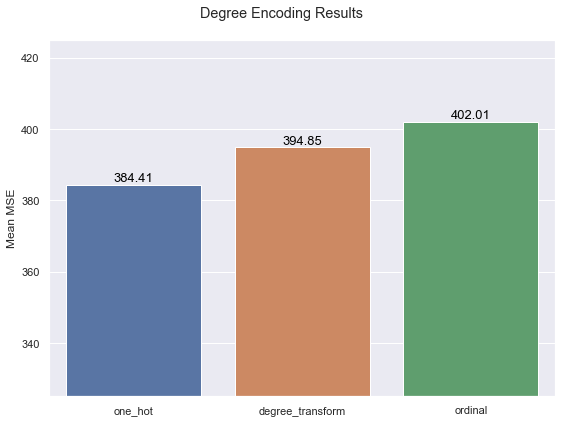

In [19]:
# plotting
plot_results(results, "Degree Encoding Results")